## Price Estimator Model: Notebook Workflow

This notebook details the process of building a price estimator model for BMW Series 3 cars. The key steps undertaken are:

1.  **Data Loading and Initial Cleaning:**
    *   Load the dataset from a CSV file.
    *   Handle duplicate entries based on the 'URL' column.
    *   Convert the 'Price (EUR)' column to a numeric type and remove rows with missing prices.

2.  **Exploratory Data Analysis (EDA) and Visualization:**
    *   Generate descriptive statistics for numerical features.
    *   Visualize the distribution of 'Price (EUR)' and identify its right-skewed nature.
    *   Analyze correlations between numerical features, leading to the decision to log-transform the price.
    *   Visualize the distribution of the log-transformed price (`Price_log`).
    *   Analyze categorical features ('Model', 'Fuel Type', 'Location') against `Price_log` using box plots to understand their impact.

3.  **Feature Engineering:**
    *   Create a 'Car Age' feature from the 'Year' of manufacture (using 2025 as the current year).
    *   Extract 'Is_xDrive' (binary) and 'Engine_Badge' (categorical) features from the 'Model' string. Rare 'Engine_Badge' values are grouped.
    *   Simplify 'Fuel Type' categories (e.g., 'Benzina + GPL' to 'Benzina', 'Hibrid Plug-In' to 'Hibrid').
    *   Map 'Location' to broader 'Region' categories.
    *   One-hot encode categorical features: 'Fuel Type', 'Region', and 'Engine_Badge'.
    *   Standardize numerical features ('Engine Size (cm3)', 'Horse Power (HP)', 'Kilometers', 'Car Age') and the target variable `Price_log` using `StandardScaler`.
    *   Drop original columns that are no longer needed for modeling (e.g., 'Model', 'Location', 'Year', 'Price (EUR)').

4.  **Model Selection, Training, and Evaluation:**
    *   Split the processed data into training and testing sets.
    *   Initialize and train several regression models: Linear Regression, Ridge Regression, Lasso Regression, Random Forest Regressor, and Gradient Boosting Regressor.
    *   Evaluate models using MAE, MSE, RMSE, and R² metrics on the test set. Gradient Boosting and Random Forest are identified as top performers.

5.  **Final Model Training, Prediction, and Saving:**
    *   Retrain the best-performing model (Gradient Boosting Regressor) on a new random split of the data.
    *   Evaluate the final model's performance.
    *   Save the trained model (`best_model.pkl`), the scaler (`scaler.pkl`), and the list of training column names (`training_columns.json`) for future use.

6.  **Prediction Function for New Data:**
    *   Define a Python function `predict_price` that encapsulates all necessary preprocessing steps (feature engineering, one-hot encoding, column alignment, scaling) and uses the saved model and scaler to predict the price of new, unseen car data.
    *   Provide an example of how to use this function with sample input.


In [200]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import joblib
import json
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [201]:
# Data loading
df = pd.read_csv("csvs/seria3_20250609_153647.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Model              922 non-null    object
 1   Engine Size (cm3)  922 non-null    int64 
 2   Horse Power (HP)   922 non-null    int64 
 3   Year               922 non-null    int64 
 4   Location           922 non-null    object
 5   Kilometers         922 non-null    int64 
 6   Fuel Type          922 non-null    object
 7   Price (EUR)        922 non-null    int64 
 8   URL                922 non-null    object
dtypes: int64(5), object(4)
memory usage: 65.0+ KB


## Data Cleaning

In this section, we perform several data cleaning steps to prepare the dataset for analysis and modeling:

1.  **Handle Duplicates:** We check for and remove any duplicate listings based on the 'URL' column, as each listing should be unique. We keep the first occurrence of any duplicate.
2.  **Drop Unnecessary Columns:** The 'URL' column is dropped after handling duplicates as it's no longer needed for the analysis.
3.  **Convert Price to Numeric:** The 'Price (EUR)' column is converted to a numeric type. This involves removing commas and handling potential errors during conversion by coercing them to NaN.
4.  **Handle Missing Price Values:** Any rows with NaN values in the 'Price (EUR)' column (resulting from conversion errors or original missing data) are dropped.
5.  **Reset Index:** After removing rows, the DataFrame index is reset to ensure it's contiguous.

In [202]:
# Checking if there are any duplicates based on 'URL' - this should be unique and specific to each listing
duplicates = df.duplicated(subset=["URL"], keep=False)

# If there are duplicates, we will print them out
if duplicates.any():
    print("Found duplicates based on 'URL':")
    print(df[duplicates])
    df.drop_duplicates(subset=["URL"], keep='first', inplace=True)
    print("Duplicates have been removed, keeping the first occurrence.")
else:
    print("No duplicates found based on 'URL'.")

df = df.drop(columns=["URL"])

No duplicates found based on 'URL'.


In [203]:
# Converting 'Price (EUR)' to numeric, handling commas and stripping whitespace as a precaution
df['Price (EUR)'] = pd.to_numeric(df["Price (EUR)"].astype(str).str.replace(",", "").str.strip(), errors="coerce")

# Checking if there are any NaN values in 'Price (EUR)' after conversion
if df['Price (EUR)'].isna().any():
    print("There are NaN values in 'Price (EUR)' after conversion. These will be dropped.")
    df = df.dropna(subset=['Price (EUR)'])

# Resetting the index after dropping duplicates and NaN values
df.reset_index(drop=True, inplace=True)

# Short a short summary of the DataFrame
print("DataFrame summary after cleaning:")
print(df.info())


DataFrame summary after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Model              922 non-null    object
 1   Engine Size (cm3)  922 non-null    int64 
 2   Horse Power (HP)   922 non-null    int64 
 3   Year               922 non-null    int64 
 4   Location           922 non-null    object
 5   Kilometers         922 non-null    int64 
 6   Fuel Type          922 non-null    object
 7   Price (EUR)        922 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 57.8+ KB
None


## 1. Exploratory Data Analysis (EDA) and Visualization

*(Code and observations for EDA will go here. Focus on understanding feature distributions and their relationship with `Price (EUR)`)*

Descriptive Statistics:
              Model  Engine Size (cm3)  Horse Power (HP)         Year  \
count           922         922.000000        922.000000   922.000000   
unique          270                NaN               NaN          NaN   
top     BMW Seria 3                NaN               NaN          NaN   
freq            224                NaN               NaN          NaN   
mean            NaN        2010.977223        172.938178  2014.931670   
std             NaN         168.648497         36.386117     5.616276   
min             NaN        1499.000000         86.000000  1976.000000   
25%             NaN        1995.000000        150.000000  2012.000000   
50%             NaN        1995.000000        183.500000  2015.000000   
75%             NaN        1995.000000        185.000000  2020.000000   
max             NaN        2996.000000        740.000000  2025.000000   

         Location     Kilometers Fuel Type   Price (EUR)  
count         922     922.000000       9

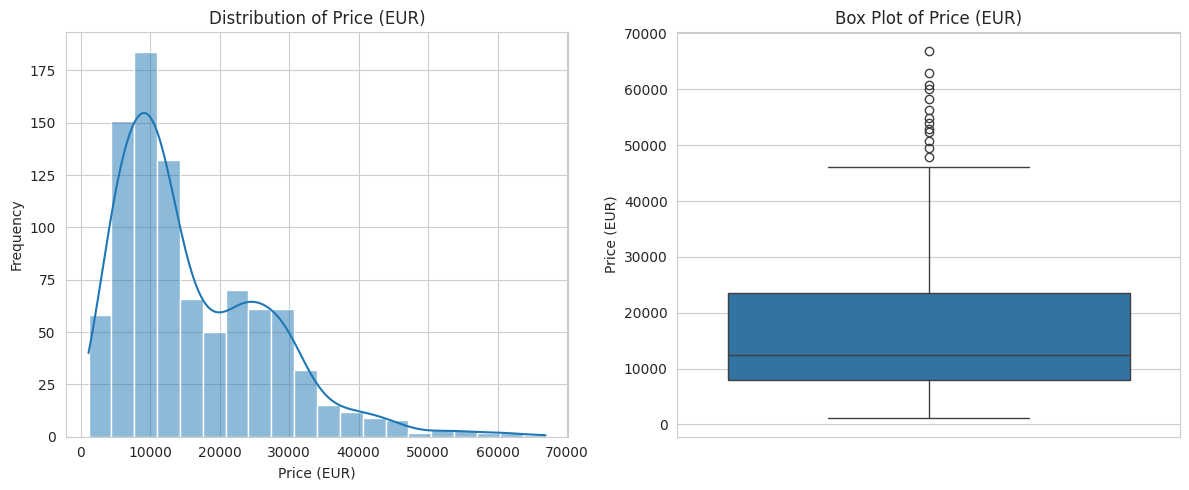

In [204]:
# Set a style for the plots
sns.set_style("whitegrid")

# Display descriptive statistics for numerical features
print("Descriptive Statistics:")
print(df.describe(include='all'))

# Visualize the distribution of the target variable 'Price (EUR)'
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Price (EUR)'], kde=True, bins=20)
plt.title('Distribution of Price (EUR)')
plt.xlabel('Price (EUR)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['Price (EUR)'])
plt.title('Box Plot of Price (EUR)')
plt.ylabel('Price (EUR)')

plt.tight_layout()
plt.show()

### EDA Summary and Conclusions:

**1. Dataset Overview**

The cleaned dataset includes 922 records with 8 features (5 numerical, 3 categorical) and no missing values. `Price (EUR)` is the target variable for prediction.

*   **Numerical Features (5):** `Engine Size (cm3)`, `Horse Power (HP)`, `Year`, `Kilometers`, `Price (EUR)`
*   **Categorical Features (3):** `Model`, `Location`, `Fuel Type`

**2. Key Findings & Analysis**

**a) Price Analysis**
*   **Right-Skewed Distribution:** The price is heavily right-skewed, with most cars clustered at lower prices and a few expensive outliers pulling the average up.
*   **Central Tendency:** The mean price (€16,145) is inflated by these outliers; the median price (€12,495) better represents a typical car's value.
*   **Outliers & Range:** The box plot confirms numerous high-end outliers, with prices ranging from €1,100 to €66,900. The most valuable vehicles drive this wide distribution.

**b) Other Numerical Features**
*   **Year:** Models range from 1976 to 2025, with a median of 2015.
*   **Kilometers:** Mileage is high, with a median of 201,282 km, indicating most cars are well-used.
*   **Engine Size:** Most cars share a 1995 cm³ engine size, showing limited variety in this feature for the bulk of the dataset.
*   **Horse Power (HP):** A wide HP range (86 to 740) suggests the presence of high-performance models, which likely correspond to the high-price outliers.

**3. Conclusions & Next Steps**

*   **Handle Price Skewness:** The price is not normally distributed. Applying a log transformation to `Price (EUR)` is recommended for modeling to normalize the distribution and lessen the impact of outliers.
*   **Key Price Predictors:** `Year`, `Kilometers`, and `Horse Power` are hypothesized to be the strongest predictors of price.

**Next Steps:**

*   **Correlation Analysis:** Use a heatmap to confirm relationships between numerical features and price.
*   **Categorical Analysis:** Use box plots to analyze how `Model`, `Fuel Type`, and `Location` impact price.
*   **Feature Engineering:** Create a `Car Age` feature from `Year` to potentially improve model performance.

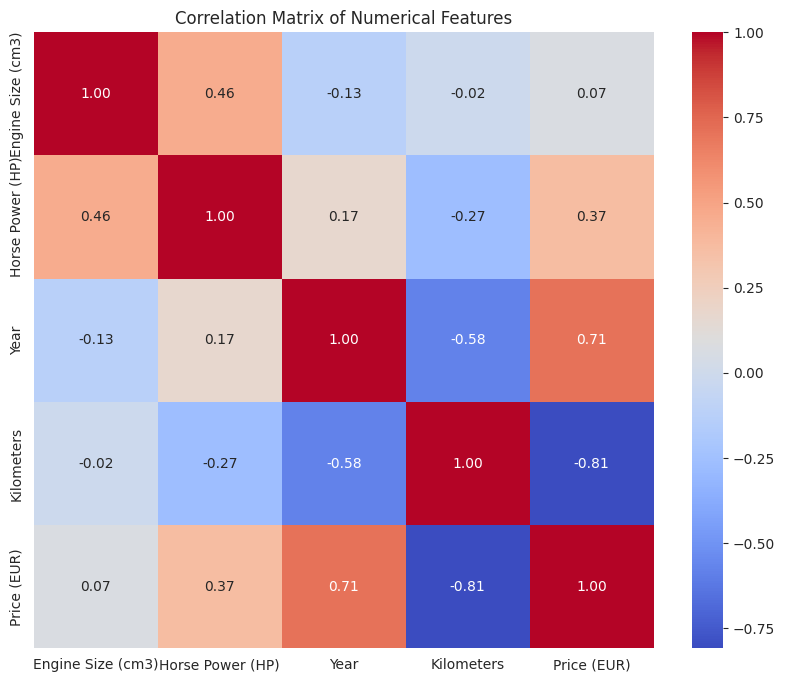

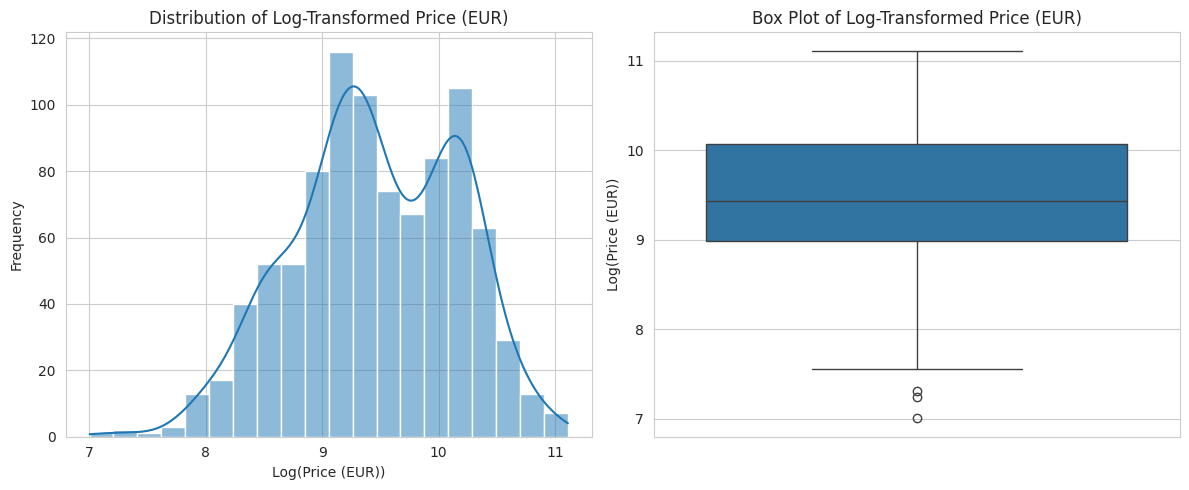

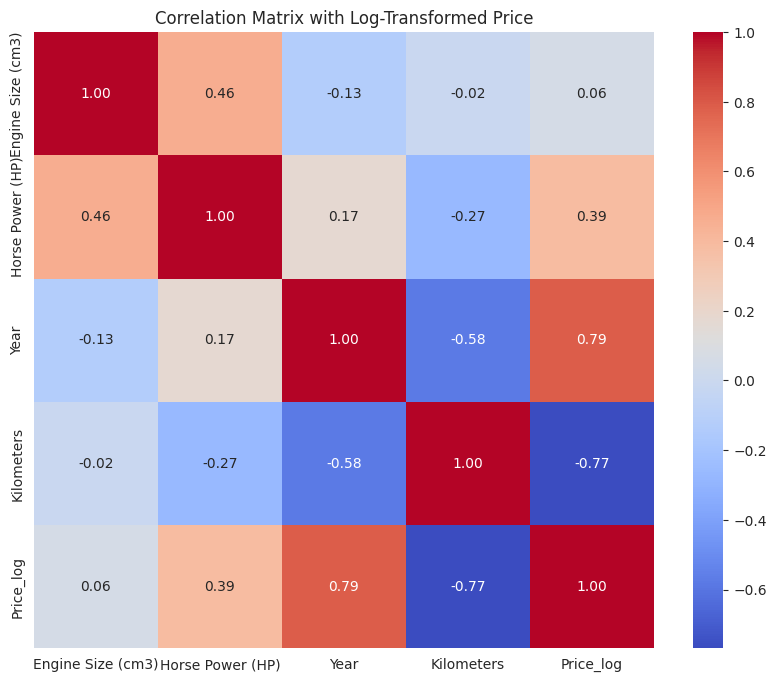

In [205]:
# Correlation Analysis

# Calculate the correlation matrix for numerical features
correlation_matrix = df[['Engine Size (cm3)', 'Horse Power (HP)', 'Year', 'Kilometers', 'Price (EUR)']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Log transform the 'Price (EUR)' column as suggested
df['Price_log'] = np.log(df['Price (EUR)'])

# Visualize the distribution of the log-transformed price
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Price_log'], kde=True, bins=20)
plt.title('Distribution of Log-Transformed Price (EUR)')
plt.xlabel('Log(Price (EUR))')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['Price_log'])
plt.title('Box Plot of Log-Transformed Price (EUR)')
plt.ylabel('Log(Price (EUR))')

plt.tight_layout()
plt.show()

# Recalculate correlation with log-transformed price
correlation_matrix_log = df[['Engine Size (cm3)', 'Horse Power (HP)', 'Year', 'Kilometers', 'Price_log']].corr()

# Plot the heatmap with log-transformed price
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_log, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix with Log-Transformed Price')
plt.show()

### EDA Summary and Conclusions (Post-Transformation and Correlation Analysis):

**1. Price Transformation**

As identified in the initial analysis, the `Price (EUR)` variable was heavily right-skewed. To address this and better meet the assumptions of linear regression models, a logarithmic transformation was applied.

*Result of Transformation:* The distribution of the log-transformed price (`Price_log`) is now approximately normal (though slightly bimodal), as seen in the histogram. The box plot confirms that this transformation has significantly reduced the number and extremity of outliers, creating a more balanced distribution. This is a crucial step for improving the performance and stability of many predictive models.

**2. Correlation Analysis**

A correlation matrix was generated to quantify the linear relationships between the numerical variables. The analysis was performed both before and after the price transformation. The key findings are consistent across both matrices, but the log transformation slightly strengthened the linear relationships.

**a) Key Relationships with Price (`Price_log`)**

The analysis confirms the initial hypotheses about which factors most strongly influence a car's price:

*   **Year (Correlation: 0.79 with `Price_log`):** There is a strong positive correlation between the year of manufacture and the price. This is the strongest predictive relationship, indicating that newer cars are significantly more expensive.
*   **Kilometers (Correlation: -0.77 with `Price_log`):** There is a strong negative correlation between the kilometers driven and the price. As mileage increases, the car's value decreases substantially.
*   **Horse Power (HP) (Correlation: 0.39 with `Price_log`):** There is a moderate positive correlation between horsepower and price. Cars with more powerful engines tend to be more expensive.
*   **Engine Size (cm3) (Correlation: 0.06 with `Price_log`):** There is a very weak to nonexistent linear correlation between engine size and price. This suggests that engine size, on its own, is not a good linear predictor of price for this dataset.

**b) Multicollinearity**

The correlation matrix also reveals relationships between the predictor variables themselves, which is important to note for modeling:

*   **Year and Kilometers (-0.58):** A moderate negative correlation exists, which is logical: newer cars tend to have fewer kilometers.
*   **Engine Size and Horse Power (0.46):** A moderate positive correlation exists, as larger engines typically produce more horsepower.

While these correlations are not severe, they indicate some multicollinearity, which should be kept in mind when interpreting the coefficients of linear models.

**3. Conclusions & Next Steps**

*   **Log Transformation is Effective:** Applying a log transformation to the `Price (EUR)` variable was a successful strategy. It normalized the distribution and created stronger linear relationships with key predictor variables, which will benefit model performance. The transformed `Price_log` should be used as the target variable for modeling.
*   **Primary Predictors Identified:** `Year` and `Kilometers` are confirmed to be the most important predictors of a used car's price. `Horse Power` is also a relevant predictor, while `Engine Size` appears to have little direct linear influence.
*   **Modeling Strategy:** Based on these findings, a linear regression model using `Year`, `Kilometers`, and `Horse Power (HP)` to predict `Price_log` would be a strong starting point. The categorical features (`Model`, `Fuel Type`, `Location`) should also be incorporated into the model to capture their impact on price.

**Next Steps:**

*   **Categorical Analysis:** Use box plots to analyze how `Fuel Type` and `Location` impact `Price_log`.
*   **Feature Engineering:** Create a `Car Age` feature from `Year` to potentially improve model performance.

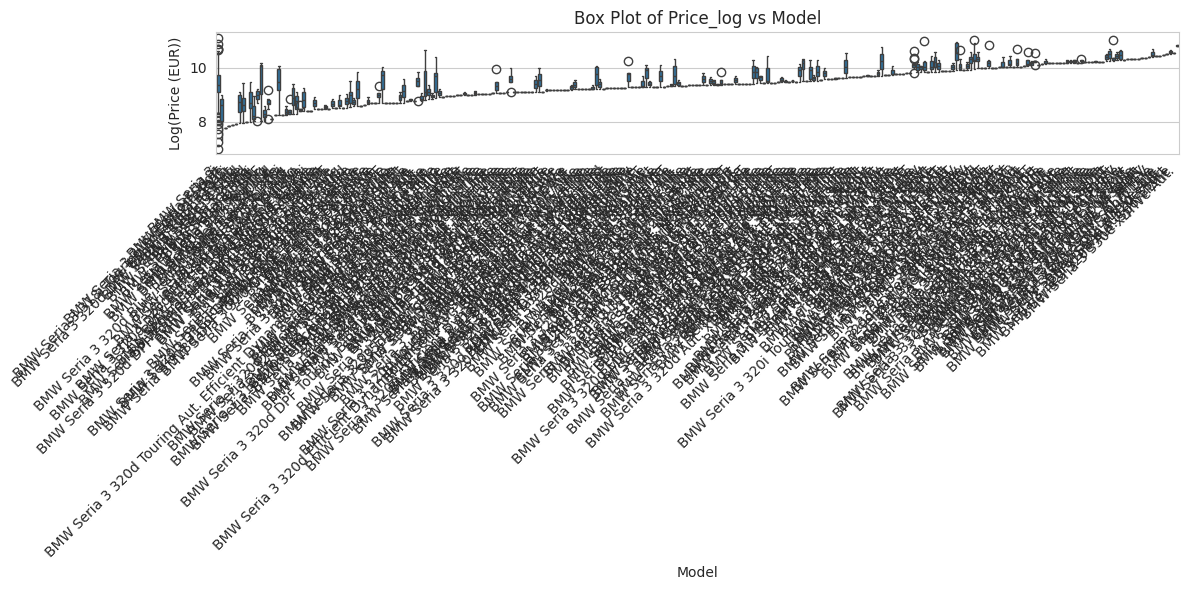


Value counts for Model:
Model
BMW Seria 3                                224
BMW Seria 3 318d                            45
BMW Seria 3 320d                            27
BMW Seria 3 320d xDrive AT MHEV             24
BMW Seria 3 330e AT PHEV                    20
                                          ... 
BMW Seria 3 330e xDrive Aut. Sport Line      1
BMW Seria 3 320i xDrive Aut.                 1
BMW Seria 3 330i Aut. Luxury Line            1
BMW Seria 3 320e Aut.                        1
BMW Seria 3 320e Aut. Sport Line             1
Name: count, Length: 270, dtype: int64
--------------------------------------------------


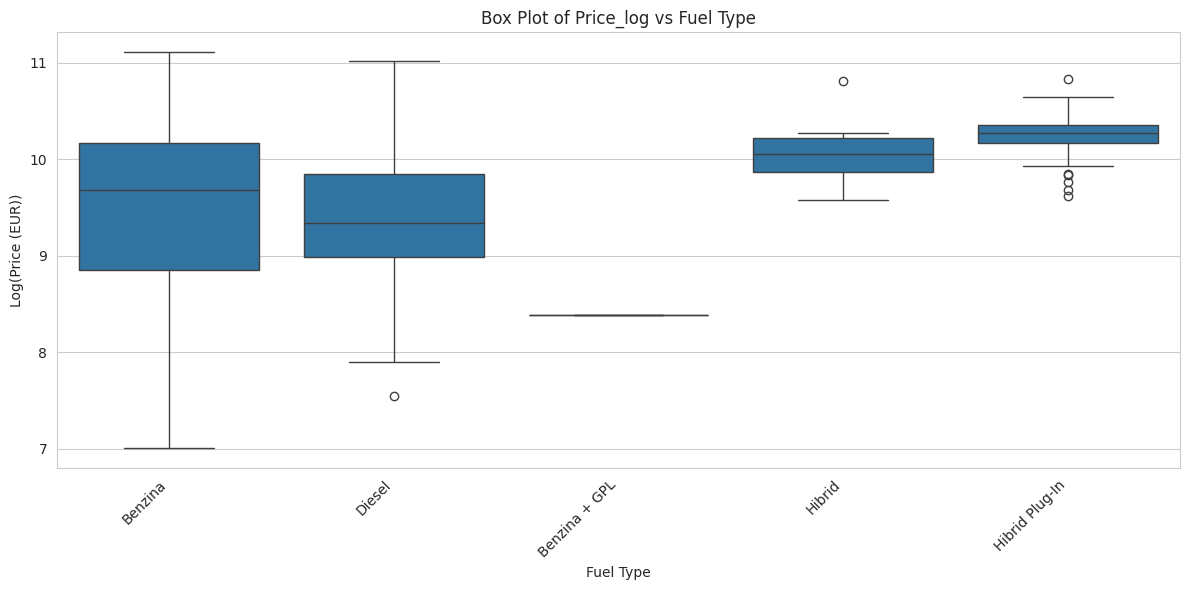


Value counts for Fuel Type:
Fuel Type
Diesel            652
Benzina           197
Hibrid Plug-In     66
Hibrid              6
Benzina + GPL       1
Name: count, dtype: int64
--------------------------------------------------


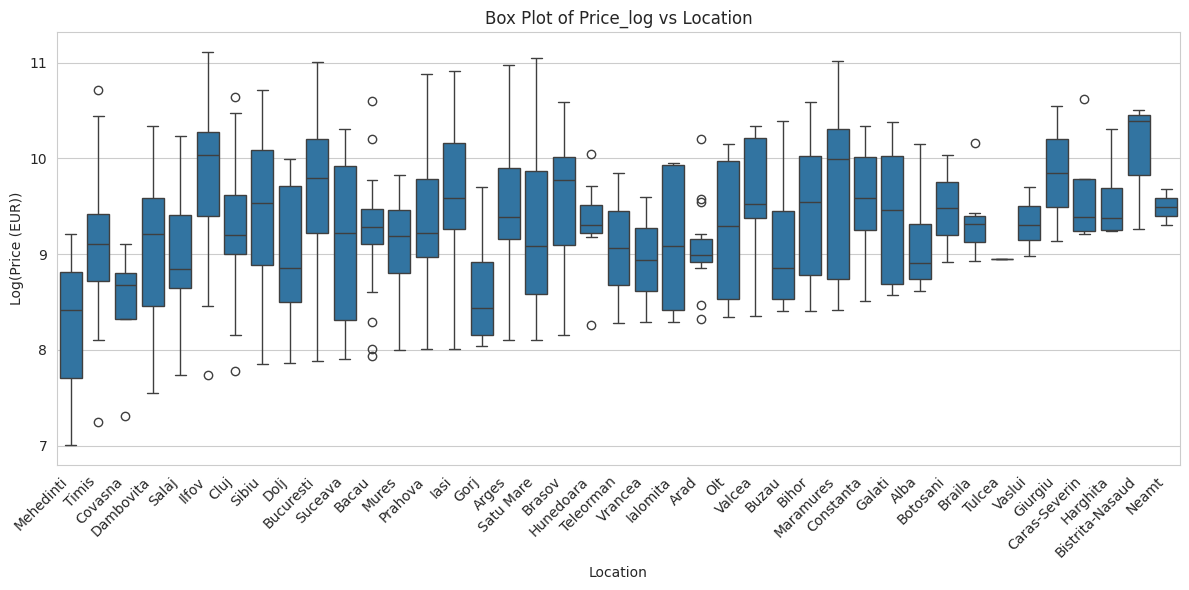


Value counts for Location:
Location
Bucuresti          239
Ilfov              102
Timis               62
Arges               52
Cluj                50
Bacau               46
Brasov              32
Prahova             28
Bihor               27
Sibiu               23
Dolj                23
Constanta           23
Iasi                21
Arad                17
Maramures           17
Mures               15
Galati              14
Satu Mare           12
Buzau               11
Valcea              10
Dambovita           10
Gorj                 9
Braila               8
Suceava              8
Salaj                7
Hunedoara            7
Olt                  6
Ialomita             5
Covasna              4
Harghita             4
Caras-Severin        4
Alba                 4
Mehedinti            3
Giurgiu              3
Vaslui               3
Bistrita-Nasaud      3
Teleorman            2
Vrancea              2
Botosani             2
Tulcea               2
Neamt                2
Name: count, dtype: 

In [206]:
# Categorical Feature Analysis

# List of categorical features to analyze
categorical_features = ['Model', 'Fuel Type', 'Location']

# Create box plots for each categorical feature against Price_log
for feature in categorical_features:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=feature, y='Price_log', data=df)
    plt.title(f'Box Plot of Price_log vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Log(Price (EUR))')
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability if many categories
    plt.tight_layout()
    plt.show()

    # Show value counts for each category to understand distribution
    print(f"\nValue counts for {feature}:")
    print(df[feature].value_counts())
    print("-"*50)

### Summary of Categorical Feature Analysis:

**Key Observations & Next Steps:**

1.  **Model:**
    *   **Impact:** Significantly influences price, with clear variations between different models.
    *   **Challenge:** High number of unique models (270), with many being rare. "BMW Seria 3" is the most common.
    *   **Strategy:** We plan to extract more granular features from the `Model` string, such as the presence of `xDrive` and the engine class (e.g., `318d`, `320d`, `330e`), where available, to create more meaningful predictors.

2.  **Fuel Type:**
    *   **Impact:** Shows a clear relationship with price. Hybrid variants (Plug-in and regular) tend to have the highest median prices, followed by Gasoline, with Diesel cars (the most numerous) having lower median prices.
    *   **Strategy:** A valuable and straightforward predictor for the model.

3.  **Location:**
    *   **Impact:** Displays some variation in price across different locations, with major areas like 'Bucuresti' and 'Ilfov' showing a wider price spread and more listings.
    *   **Strategy:** Potentially useful. Consider grouping locations with very few listings.

**Overall Modeling Implications:**

*   All three categorical features (`Model`, `Fuel Type`, `Location`) are important for price prediction.
*   **Feature Engineering Plan:**
    *   **Model:** Group rare variants, then extract sub-features (e.g., `xDrive`, engine class).
    *   **Location:** Group rare locations.
    *   **Encoding:** After engineering, these categorical features (and the new ones derived from `Model`) will be encoded (e.g., using one-hot encoding) for use in the model, alongside the key numerical predictors (`Year`, `Kilometers`, `Horse Power`, and `Price_log` as the target).

## 2. Feature Engineering

In [207]:
# Create 'Car Age' feature
current_year = 2025 # As per current date context
df['Car Age'] = current_year - df['Year']

# Display the first few rows with the new feature and updated info
print("DataFrame with 'Car Age':")
print(df[['Year', 'Car Age', 'Price_log']].head())
print("\nUpdated DataFrame info:")
df.info()

DataFrame with 'Car Age':
   Year  Car Age  Price_log
0  2002       23   7.003065
1  2004       21   7.244228
2  2006       19   7.313220
3  2004       21   7.549083
4  2006       19   7.736307

Updated DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Model              922 non-null    object 
 1   Engine Size (cm3)  922 non-null    int64  
 2   Horse Power (HP)   922 non-null    int64  
 3   Year               922 non-null    int64  
 4   Location           922 non-null    object 
 5   Kilometers         922 non-null    int64  
 6   Fuel Type          922 non-null    object 
 7   Price (EUR)        922 non-null    int64  
 8   Price_log          922 non-null    float64
 9   Car Age            922 non-null    int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 72.2+ KB


In [208]:
# Extract features from Model

# Create Is_xDrive feature
df['Is_xDrive'] = df['Model'].str.contains('xDrive', case=False, na=False).astype(int)

# Extract Engine_Badge using regex
# This regex looks for patterns like 320d, 318i, 330e, M3, etc.
# It captures a '3' followed by two digits and optionally 'd', 'e', or 'i', OR 'M3'
df['Engine_Badge'] = df['Model'].str.extract(r'\b(3\d{2}[dei]?|M3)\b', flags=re.IGNORECASE)
# Fill NaN values in Engine_Badge with 'Unknown' for better analysis
df['Engine_Badge'] = df['Engine_Badge'].fillna('Unknown')
# Group rare Engine_Badge values into 'Rarer Models'
index_to_replace = df['Engine_Badge'].value_counts()[df['Engine_Badge'].value_counts() < 10].index
df['Engine_Badge'] = df['Engine_Badge'].replace(index_to_replace, 'Rarer Models')

# Replace Fuel Type 'Benzina + GPL' with 'Benzina' for consistency
df['Fuel Type'] = df['Fuel Type'].replace('Benzina + GPL', 'Benzina')
df['Fuel Type'] = df['Fuel Type'].replace('Hibrid Plug-In', 'Hibrid')

# Display value counts for the new features and a sample of the DataFrame
print("Value counts for Is_xDrive:")
print(df['Is_xDrive'].value_counts())
print('-'*50)
print("Value counts for Engine_Badge:")
print(df['Engine_Badge'].value_counts(dropna=False))
print('-'*50)
print("Sample of DataFrame with new Model features:")
print(df[['Model', 'Is_xDrive', 'Engine_Badge', 'Price_log']].head())
print('-'*50)
# Display the unique values in 'Fuel Type' after replacement
print("Unique values in 'Fuel Type' after replacement:")
print(df['Fuel Type'].unique())
print('-'*50)
df.head()

Value counts for Is_xDrive:
Is_xDrive
0    751
1    171
Name: count, dtype: int64
--------------------------------------------------
Value counts for Engine_Badge:
Engine_Badge
320d            270
Unknown         226
318d            163
320i             66
330e             56
Rarer Models     53
318i             43
316d             26
330i             19
Name: count, dtype: int64
--------------------------------------------------
Sample of DataFrame with new Model features:
              Model  Is_xDrive Engine_Badge  Price_log
0       BMW Seria 3          0      Unknown   7.003065
1       BMW Seria 3          0      Unknown   7.244228
2  BMW Seria 3 318i          0         318i   7.313220
3       BMW Seria 3          0      Unknown   7.549083
4       BMW Seria 3          0      Unknown   7.736307
--------------------------------------------------
Unique values in 'Fuel Type' after replacement:
['Benzina' 'Diesel' 'Hibrid']
--------------------------------------------------


,Model,Engine Size (cm3),Horse Power (HP),Year,Location,Kilometers,Fuel Type,Price (EUR),Price_log,Car Age,Is_xDrive,Engine_Badge
0,BMW Seria 3,1796,115,2002,Mehedinti,189000,Benzina,1100,7.003065,23,0,Unknown
1,BMW Seria 3,1796,115,2004,Timis,192000,Benzina,1400,7.244228,21,0,Unknown
2,BMW Seria 3 318i,1995,129,2006,Covasna,255000,Benzina,1500,7.313220,19,0,318i
3,BMW Seria 3,1995,150,2004,Dambovita,350000,Diesel,1899,7.549083,21,0,Unknown
4,BMW Seria 3,1995,129,2006,Salaj,320000,Benzina,2290,7.736307,19,0,Unknown


Value counts for Region:
Region
Bucuresti    239
Center       232
North        198
South        151
Ilfov        102
Name: count, dtype: int64


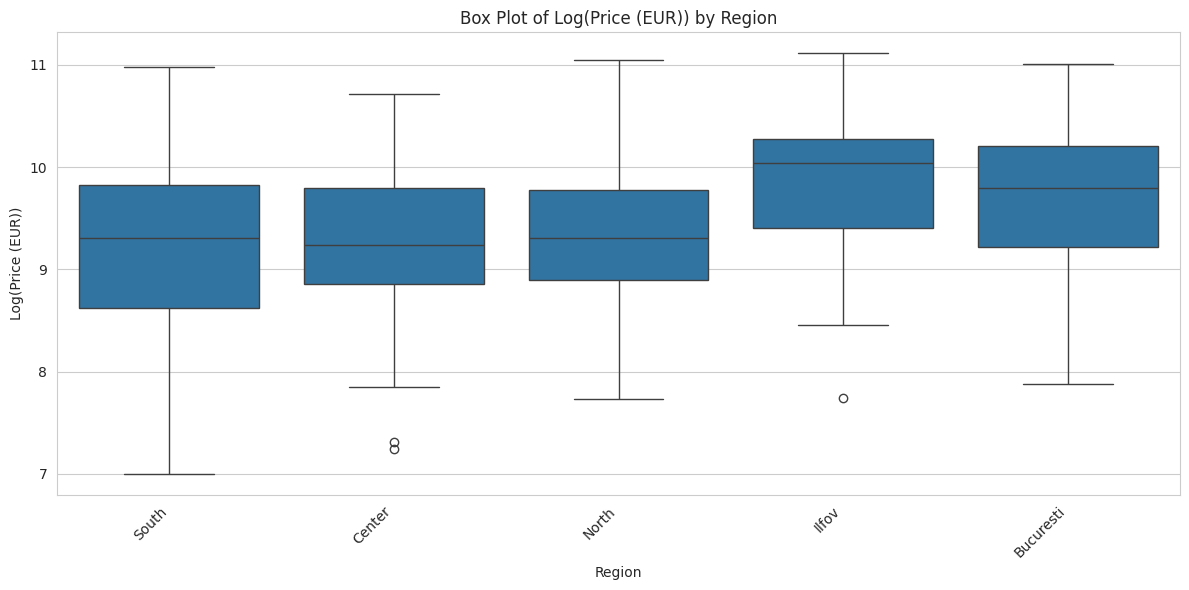

In [209]:
location_to_region_map = {
    # Bucharest
    'Bucuresti': 'Bucuresti',
    'Ilfov': 'Ilfov',

    # Center
    'Alba': 'Center',
    'Brasov': 'Center',
    'Covasna': 'Center',
    'Harghita': 'Center',
    'Mures': 'Center',
    'Sibiu': 'Center',

    # North
    'Bihor': 'North',
    'Bistrita-Nasaud': 'North',
    'Cluj': 'North',
    'Maramures': 'North',
    'Satu Mare': 'North',
    'Salaj': 'North',
    'Bacau': 'North',
    'Botosani': 'North',
    'Iasi': 'North',
    'Neamt': 'North',
    'Suceava': 'North',
    'Vaslui': 'North',

    # West
    'Arad': 'Center',
    'Caras-Severin': 'Center',
    'Hunedoara': 'Center',
    'Timis': 'Center',

    # East
    'Braila': 'Center',
    'Buzau': 'Center',
    'Constanta': 'Center',
    'Galati': 'Center',
    'Tulcea': 'Center',
    'Vrancea': 'Center',

    # South
    'Arges': 'South',
    'Calarasi': 'South',
    'Dambovita': 'South',
    'Giurgiu': 'South',
    'Ialomita': 'South',
    'Prahova': 'South',
    'Teleorman': 'South',
    'Dolj': 'South',
    'Gorj': 'South',
    'Mehedinti': 'South',
    'Olt': 'South',
    'Valcea': 'South',
}


# Map the 'Location' to 'Region'
df['Region'] = df['Location'].map(location_to_region_map).fillna('Other_Region')

# Display the value counts for the new 'Region' feature
print("Value counts for Region:")
print(df['Region'].value_counts())

# Visualize the distribution of Price_log by Region
plt.figure(figsize=(12, 6))
sns.boxplot(x='Region', y='Price_log', data=df)
plt.title('Box Plot of Log(Price (EUR)) by Region')
plt.xlabel('Region')
plt.ylabel('Log(Price (EUR))')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [210]:
# Encoding categorical features for modeling
categorical_features = ['Fuel Type', 'Region', 'Engine_Badge']
# One-hot encoding for categorical features
df_encoded = pd.get_dummies(df, columns=categorical_features)
# Drop the 'Model', 'Location', 'Year', and 'Price (EUR)' columns as they are not needed for modeling
df_encoded = df_encoded.drop(columns=['Model', 'Location', 'Year', 'Price (EUR)'])
# Reset index after encoding
df_encoded.reset_index(drop=True, inplace=True)
# Display the first few rows of the encoded DataFrame
print("Encoded DataFrame with one-hot encoding for categorical features:")
print(df_encoded.head())
print('-'*50)

Encoded DataFrame with one-hot encoding for categorical features:
   Engine Size (cm3)  Horse Power (HP)  Kilometers  Price_log  Car Age  \
0               1796               115      189000   7.003065       23   
1               1796               115      192000   7.244228       21   
2               1995               129      255000   7.313220       19   
3               1995               150      350000   7.549083       21   
4               1995               129      320000   7.736307       19   

   Is_xDrive  Fuel Type_Benzina  Fuel Type_Diesel  Fuel Type_Hibrid  \
0          0               True             False             False   
1          0               True             False             False   
2          0               True             False             False   
3          0              False              True             False   
4          0               True             False             False   

   Region_Bucuresti  ...  Region_South  Engine_Badge_316d  Eng

In [211]:
# Initialize the scaler
scaler = StandardScaler()
# Fit and transform the numerical features
numerical_features = ['Engine Size (cm3)', 'Horse Power (HP)', 'Kilometers', 'Car Age', 'Price_log']
df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])
# Display the first few rows of the scaled DataFrame
print("Scaled DataFrame with standardized numerical features:")
print(df_encoded.head())

Scaled DataFrame with standardized numerical features:
   Engine Size (cm3)  Horse Power (HP)  Kilometers  Price_log   Car Age  \
0          -1.275398         -1.593180   -0.052324  -3.490528  2.303784   
1          -1.275398         -1.593180   -0.017920  -3.147700  1.947483   
2          -0.094788         -1.208209    0.704561  -3.049622  1.591182   
3          -0.094788         -0.630752    1.794016  -2.714328  1.947483   
4          -0.094788         -1.208209    1.449978  -2.448176  1.591182   

   Is_xDrive  Fuel Type_Benzina  Fuel Type_Diesel  Fuel Type_Hibrid  \
0          0               True             False             False   
1          0               True             False             False   
2          0               True             False             False   
3          0              False              True             False   
4          0               True             False             False   

   Region_Bucuresti  ...  Region_South  Engine_Badge_316d  Engine_B

### Summary of Feature Engineering and Data Preparation:

This section focused on creating new features and preparing the data for modeling:

*   **`Car Age`**:
    *   Created by subtracting `Year` from 2025.
    *   Provides a direct measure of vehicle age.
    *   **Status**: Included in the final scaled numerical features.

*   **`Is_xDrive`**:
    *   Binary feature (0/1) extracted from the `Model` string, indicating the presence of "xDrive".
    *   **Status**: Included as a binary feature.

*   **`Engine_Badge`**:
    *   Extracted from the `Model` string (e.g., "320d", "330e") using regular expressions.
    *   NaN values were filled with 'Unknown'.
    *   Categories with fewer than 10 occurrences were grouped into 'Rarer Models'.
    *   **Status**: Processed and then one-hot encoded.

*   **`Region`**:
    *   Created by mapping `Location` (county/city) to broader geographical regions.
    *   Locations not in the map were categorized as 'Other_Region'.
    *   **Status**: Processed and then one-hot encoded.

*   **`Fuel Type` Simplification**:
    *   'Benzina + GPL' was mapped to 'Benzina'.
    *   'Hibrid Plug-In' was mapped to 'Hibrid'.
    *   **Status**: Simplified and then one-hot encoded.

**Data Preparation Steps:**

1.  **Categorical Feature Encoding**:
    *   `Fuel Type`, `Region`, and the processed `Engine_Badge` were converted to numerical format using one-hot encoding (`pd.get_dummies`).
    *   `Is_xDrive` was already in a binary numerical format and was retained.

2.  **Numerical Feature Scaling**:
    *   The following numerical features were standardized using `StandardScaler`: `Engine Size (cm3)`, `Horse Power (HP)`, `Kilometers`, and `Car Age`.
    *   The target variable `Price_log` was also scaled.

3.  **Column Dropping**:
    *   The original columns `Model`, `Location`, `Year`, and `Price (EUR)` were dropped as they were replaced by engineered features or are no longer needed for modeling.

**Overall**: The DataFrame `df_encoded` now contains the fully processed features ready for model training. This includes scaled numerical features, a binary feature for xDrive, and one-hot encoded categorical features. The target variable `Price_log` has also been scaled.

## 5. Model Selection, Training, and Evaluation

Now that the data is prepared, we can proceed with selecting, training, and evaluating regression models to predict car prices.

In [212]:
# Define features (X) and target (y)
# Price_log is our target variable
X = df_encoded.drop('Price_log', axis=1)
y = df_encoded['Price_log']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (737, 22)
X_test shape: (185, 22)
y_train shape: (737,)
y_test shape: (185,)


In [213]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(random_state=42),
    "Lasso Regression": Lasso(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Dictionary to store evaluation metrics
results = {}

In [214]:
# Train and evaluate each model
for name, model in models.items():
    # print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    # print(f"Evaluating {name}...")
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2
    }
    # print(f"{name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}\n")

# Display results
results_df = pd.DataFrame(results).T.sort_values(by="R2", ascending=False)
print("\nModel Performance Summary:")
print(results_df)


Model Performance Summary:
                        MAE       MSE      RMSE        R2
Gradient Boosting  0.219225  0.087975  0.296606  0.909830
Random Forest      0.220474  0.091473  0.302445  0.906245
Ridge Regression   0.281957  0.147122  0.383565  0.849208
Linear Regression  0.282008  0.147459  0.384003  0.848863
Lasso Regression   0.827153  0.975958  0.987906 -0.000303


### Interpretation of Model Results:

*   **MAE (Mean Absolute Error)**: Average absolute difference between predicted and actual values (on the scaled `Price_log`). Lower is better.
*   **MSE (Mean Squared Error)**: Average of the squares of the errors. Penalizes larger errors more. Lower is better.
*   **RMSE (Root Mean Squared Error)**: Square root of MSE. Interpretable in the same units as the target variable (scaled `Price_log`). Lower is better.
*   **R² (R-squared)**: Proportion of the variance in `Price_log` that is predictable from the features. Ranges from 0 to 1, higher is better.

**Based on the results:**

*   **Top Performers**: `Gradient Boosting` (R²: 0.909, RMSE: 0.296) and `Random Forest` (R²: 0.906, RMSE: 0.302) performed the best. They have the highest R² values, indicating they explain over 90% of the variance in the log-transformed prices, and also have the lowest error metrics (MAE, MSE, RMSE).
*   **Linear Models**: `Ridge Regression` (R²: 0.849) and `Linear Regression` (R²: 0.848) performed reasonably well, explaining about 85% of the variance. Their error metrics are slightly higher than the ensemble methods.
*   **Lasso Regression**: Performed very poorly (R²: ~0.00), suggesting it was not able to capture the relationships in the data effectively with the current features and scaling, likely due to too much regularization shrinking coefficients to near zero.

**Conclusion**: The ensemble methods, particularly Gradient Boosting and Random Forest, are the strongest candidates for this price prediction task. They provide a good balance of predictive power and relatively low error.

## 6. Final Model Training, Prediction and Saving
The final model training and prediction process involves selecting the best-performing model from the evaluation phase, retraining it on the entire dataset, and then saving the model for future use.

In [215]:
# Split once more the data for final training - this time randomly
X_final_train, X_final_test, y_final_train, y_final_test = train_test_split(X, y, test_size=0.2)

# Train the best model (Gradient Boosting in this case) on the final training set
best_model = GradientBoostingRegressor()
best_model.fit(X_final_train, y_final_train)

# Make predictions on the final test set
y_final_pred = best_model.predict(X_final_test)

# Evaluate the final model
final_mae = mean_absolute_error(y_final_test, y_final_pred)
final_mse = mean_squared_error(y_final_test, y_final_pred)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_final_test, y_final_pred)
print("\nFinal Model Performance:")
print(f"MAE: {final_mae:.4f}, MSE: {final_mse:.4f}, RMSE: {final_rmse:.4f}, R2: {final_r2:.4f}")


Final Model Performance:
MAE: 0.2190, MSE: 0.1008, RMSE: 0.3176, R2: 0.9015


In [ ]:
folder = "backend/notebook_output"
# Save the final model for future use
joblib.dump(best_model, f'{folder}/best_model.pkl')

# Save the scaler for future use
joblib.dump(scaler, f'{folder}/scaler.pkl')

# Save the training columns 
training_cols_list = X_final_train.columns.tolist()
with open(f'{folder}/training_columns.json', 'w') as f:
    json.dump(training_cols_list, f)

## 6. How to Make Predictions on New Unseen Data

To use the trained Gradient Boosting model (`best_model.pkl`) and the scaler (`scaler.pkl`) for predicting the price of a new car, the following steps must be performed consistently with how the training data was processed. The `training_columns.json` file is crucial for aligning features after one-hot encoding.

1.  **Load Artifacts**:
    *   Load the trained model: `model = joblib.load('best_model.pkl')`.
    *   Load the fitted scaler: `scaler = joblib.load('scaler.pkl')`.
    *   Load the list of training column names: `with open('training_columns.json', 'r') as f: training_columns = json.load(f)`.

2.  **Prepare Input Data**:
    *   The new car data should be in a pandas DataFrame.
    *   It must contain the raw features required to derive all model inputs (e.g., `Year`, `Model` (for `Is_xDrive`), `Fuel Type`, `Region`, `Engine_Badge`, `Engine Size (cm3)`, `Horse Power (HP)`, `Kilometers`).

3.  **Feature Engineering** (Replicate training process):
    *   **`Car Age`**: Calculate `Car Age = 2025 - Year`. (Ensure '2025' matches the reference year from training, which is the current year).
    *   **`Is_xDrive`**: Extract from the `Model` string (e.g., `input_df['Model'].str.contains('xDrive', case=False, na=False).astype(int)`).
    *   **`Fuel Type` Simplification**: Apply mappings like 'Benzina + GPL' to 'Benzina', 'Hibrid Plug-In' to 'Hibrid'.
    *   *(Ensure `Engine_Badge` and `Region` are provided directly in the input or derived consistently if your raw input has fields like a more complex `Model` string or `Location` that needs mapping to `Region`.)*

4.  **One-Hot Encoding**:
    *   Apply `pd.get_dummies()` to the categorical columns (e.g., `['Fuel Type', 'Region', 'Engine_Badge']`).
    *   Use the exact same `drop_first` setting as used during the training data preparation.

5.  **Align Columns**:
    *   After one-hot encoding, `reindex` the resulting DataFrame using the loaded `training_columns` list: `input_df_aligned = input_df_dummified.reindex(columns=training_columns, fill_value=0)`.
    *   This step is vital. It ensures the DataFrame has the exact same columns and column order as the data the model was trained on. Missing columns (e.g., categories not present in the new input but present in training) are added with `0`.

6.  **Numerical Feature Scaling**:
    *   Identify the numerical features that were scaled during training (e.g., `['Engine Size (cm3)', 'Horse Power (HP)', 'Kilometers', 'Car Age']`).
    *   **Manually scale** these features. For each feature:
        *   Retrieve its specific `mean_` and `scale_` (standard deviation) from the loaded `scaler` object. This requires knowing the order of features the scaler was originally fit on (e.g., `scaler_fit_features_ordered = ['Engine Size (cm3)', 'Horse Power (HP)', 'Kilometers', 'Car Age', 'Price_log']`).
        *   Find the index of the current feature in `scaler_fit_features_ordered` to get the correct `scaler.mean_[index]` and `scaler.scale_[index]`.
        *   Apply the formula: `scaled_value = (value - feature_mean) / feature_scale`.

7.  **Make Prediction**:
    *   Pass the fully preprocessed and scaled DataFrame (`input_df_aligned`) to `model.predict()`.
    *   This will output the scaled, log-transformed predicted price (e.g., `scaled_price_log_pred`).

8.  **Inverse Transform Prediction**:
    *   The prediction from the model is a scaled `Price_log`.
    *   **Inverse Scale**: Manually inverse scale this predicted value. You'll need the `mean_` and `scale_` for `Price_log` that the `scaler` learned during fitting (e.g., if `Price_log` was the last feature, use `scaler.mean_[-1]` and `scaler.scale_[-1]`).
        *   `original_log_price = (scaled_price_log_pred * price_log_scale_from_scaler) + price_log_mean_from_scaler`.
    *   **Exponentiate**: Apply `np.exp()` to the `original_log_price` to convert it back to the actual predicted price in EUR: `actual_price_pred = np.exp(original_log_price)`.

This structured approach ensures that new data is transformed in exactly the same way as the training data, which is essential for accurate predictions.

In [217]:
def predict_price(model_path, scaler_path, columns_path, raw_input_df):
    # Load the trained model, scaler, and training column names
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    with open(columns_path, 'r') as f:
        training_columns = json.load(f) # These are the column names the model was trained on

    input_df = raw_input_df.copy()

    # --- 1. Feature Engineering (must be consistent with training data processing) ---
    # Create 'Car Age'
    current_year = 2025 # Ensure this matches the year used during training
    input_df['Car Age'] = current_year - input_df['Year']

    # Create 'Is_xDrive' from 'Model' column
    input_df['Is_xDrive'] = input_df['Is_xDrive'].astype(int)  # Ensure it's binary (0 or 1)

    # Simplify 'Fuel Type' (example: 'Benzina + GPL' -> 'Benzina')
    input_df['Fuel Type'] = input_df['Fuel Type'].replace({
        'Benzina + GPL': 'Benzina',
        'Hibrid Plug-In': 'Hibrid'
        # Add other mappings if they were used in training
    })
    
    # Define original categorical columns that were one-hot encoded during training
    # These are the names *before* dummification (e.g., 'Fuel Type', not 'Fuel Type_Diesel')
    original_categorical_cols = ['Fuel Type', 'Region', 'Engine_Badge']

    # --- 2. One-Hot Encoding ---
    # Apply one-hot encoding. drop_first must match the setting used during training.
    input_df_dummified = pd.get_dummies(input_df, columns=original_categorical_cols)
    
    # --- 3. Align Columns with Training Data ---
    # Reindex the dummified input to match the columns seen by the model during training.
    # This adds missing columns (e.g., other Engine_Badge types) with fill_value=0
    # and ensures the correct order.
    input_df_aligned = input_df_dummified.reindex(columns=training_columns, fill_value=0)
    
    # --- 4. Scaling Numerical Features ---
    # List of numerical features that were scaled (excluding the target variable 'Price_log')
    numerical_features_to_scale = ['Engine Size (cm3)', 'Horse Power (HP)', 'Kilometers', 'Car Age']
    
    # List of all features the scaler was originally fit on, in order.
    # 'Price_log' was the 5th element (index 4) in this example list. Adjust if your order was different.
    scaler_fit_features_ordered = ['Engine Size (cm3)', 'Horse Power (HP)', 'Kilometers', 'Car Age', 'Price_log']

    for col_name in numerical_features_to_scale:
        if col_name in input_df_aligned.columns: # Ensure column exists
            try:
                # Find the index of this column in the list of features the scaler was fit on
                scaler_col_idx = scaler_fit_features_ordered.index(col_name)
                mean_val = scaler.mean_[scaler_col_idx]
                scale_val = scaler.scale_[scaler_col_idx]
                input_df_aligned[col_name] = (input_df_aligned[col_name] - mean_val) / scale_val
            except ValueError:
                print(f"Warning: Column '{col_name}' was intended for scaling but not found in scaler's original fit features list: {scaler_fit_features_ordered}")
            except IndexError:
                print(f"Warning: Index issue for column '{col_name}' during scaling. Scaler might not have been fit on this feature correctly.")
        else:
            print(f"Warning: Numerical column '{col_name}' not found in the aligned input data for scaling.")

    # --- 5. Prediction ---
    # The input_df_aligned should now have the exact feature set (names and order) as X_train.
    scaled_price_log_pred = model.predict(input_df_aligned)

    # --- 6. Inverse Transform the Prediction ---
    # 'Price_log' was the last feature the scaler was trained on (index -1).
    price_log_mean_at_fit = scaler.mean_[-1]  # Mean of 'Price_log' during scaler fit
    price_log_scale_at_fit = scaler.scale_[-1] # Scale of 'Price_log' during scaler fit
    
    # Inverse scaling for the predicted 'Price_log'
    original_price_log_pred = (scaled_price_log_pred * price_log_scale_at_fit) + price_log_mean_at_fit
    
    # Convert from log price back to actual price using np.exp()
    actual_price_pred = np.exp(original_price_log_pred)
    
    return actual_price_pred

# --- Example Usage ---
# Define the sample input data for a new car prediction
example_input_df = pd.DataFrame({
    'Engine Size (cm3)': [2000],
    'Horse Power (HP)': [184],
    'Kilometers': [143000],
    'Year': [2012],               # Used to calculate 'Car Age'
    'Is_xDrive': [1],         # Binary feature, 1 for xDrive, 0 otherwise
    'Fuel Type': ['Diesel'],      # Categorical, will be one-hot encoded
    'Region': ['Bucuresti'],       # Categorical, will be one-hot encoded
    'Engine_Badge': ['320d']    # Categorical, will be one-hot encoded
})

# Predict the price using the function
predicted_price = predict_price(
    f'{folder}/best_model.pkl', 
    f'{folder}/scaler.pkl', 
    f'{folder}/training_columns.json', 
    example_input_df)
print(f"Predicted Price (EUR): {predicted_price[0]:.2f}")

Predicted Price (EUR): 11898.92
